Загружено данных: (810, 10)
Уникальных категорий: 10


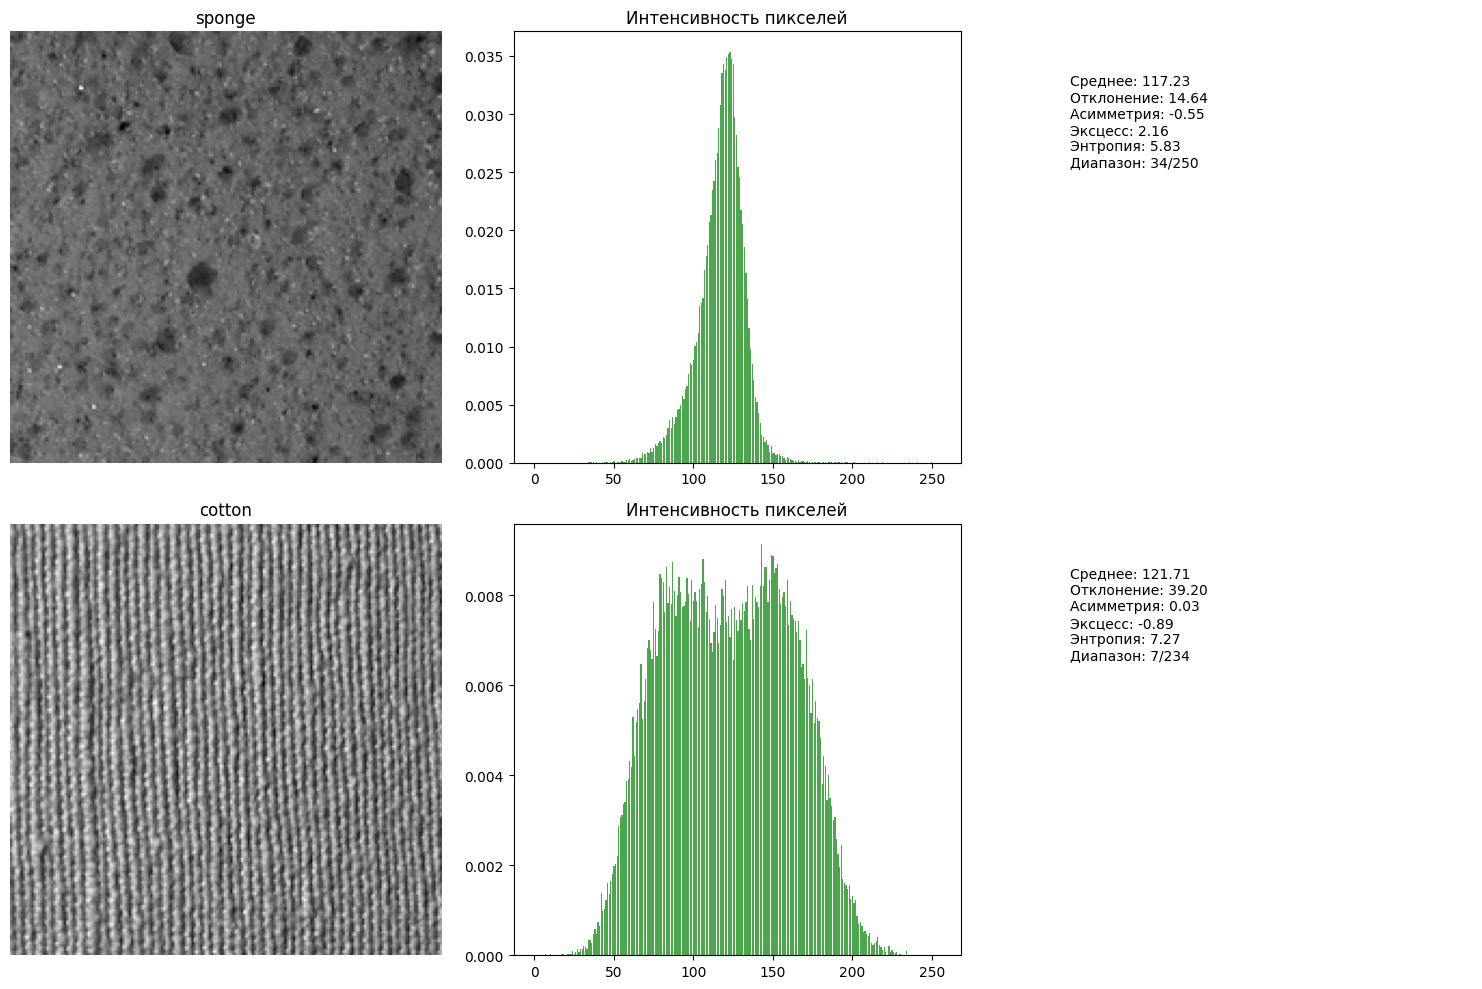

Обнаружено изображений: 810
Обработка 0/810
Обработка 50/810
Обработка 100/810
Обработка 150/810
Обработка 200/810
Обработка 250/810
Обработка 300/810
Обработка 350/810
Обработка 400/810
Обработка 450/810
Обработка 500/810
Обработка 550/810
Обработка 600/810
Обработка 650/810
Обработка 700/810
Обработка 750/810
Обработка 800/810
Размерность признаков: (810, 10)

ГИСТОГРАММА
kNN
                precision    recall  f1-score   support

aluminium_foil       0.95      0.95      0.95        20
   brown_bread       0.86      0.95      0.90        20
      corduroy       0.66      0.95      0.78        20
        cotton       0.59      0.62      0.60        21
       cracker       0.83      0.90      0.86        21
         linen       0.94      0.75      0.83        20
   orange_peel       1.00      0.90      0.95        21
     sandpaper       0.54      0.35      0.42        20
        sponge       0.83      0.75      0.79        20
     styrofoam       0.90      0.95      0.93        20

 

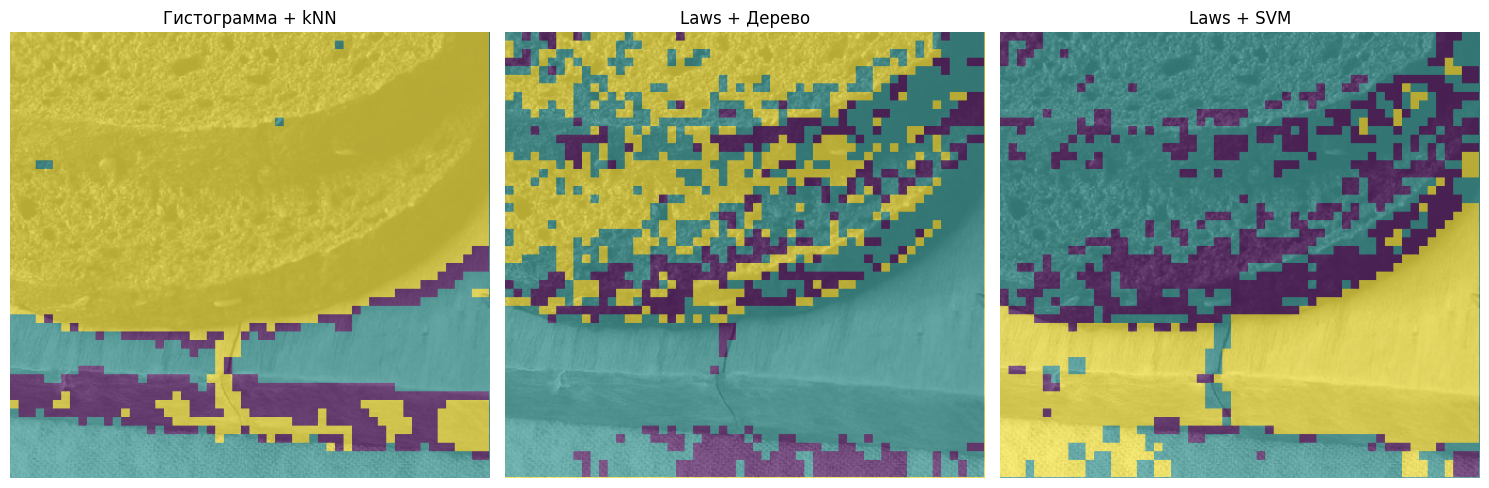

Успешно обработано: 3/3
Доминирующие цвета: [ 91 204 112]
Количество пикселей: [78636 70066 13193]
Сопоставление: [ 91 204 112] -> [0, 1, 2]


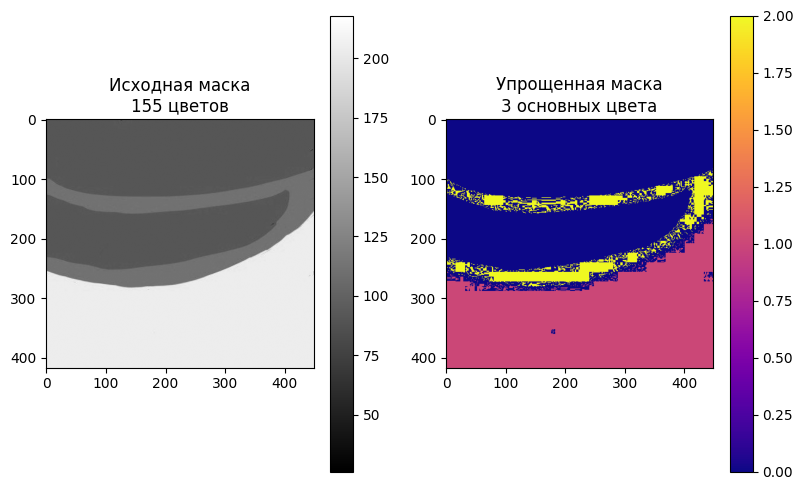

Запуск сегментации...
Классы после фильтрации: [0 1 2]
Результат: (417, 449)
Классы в результате: [0 1 2]
Классы в эталоне: [0 1 2]
Классы в предсказании: [0 1 2]
Точность: 68.3%
Метрика IoU по классам:
   Класс 0: 0.499
   Класс 1: 0.789
   Класс 2: 0.093


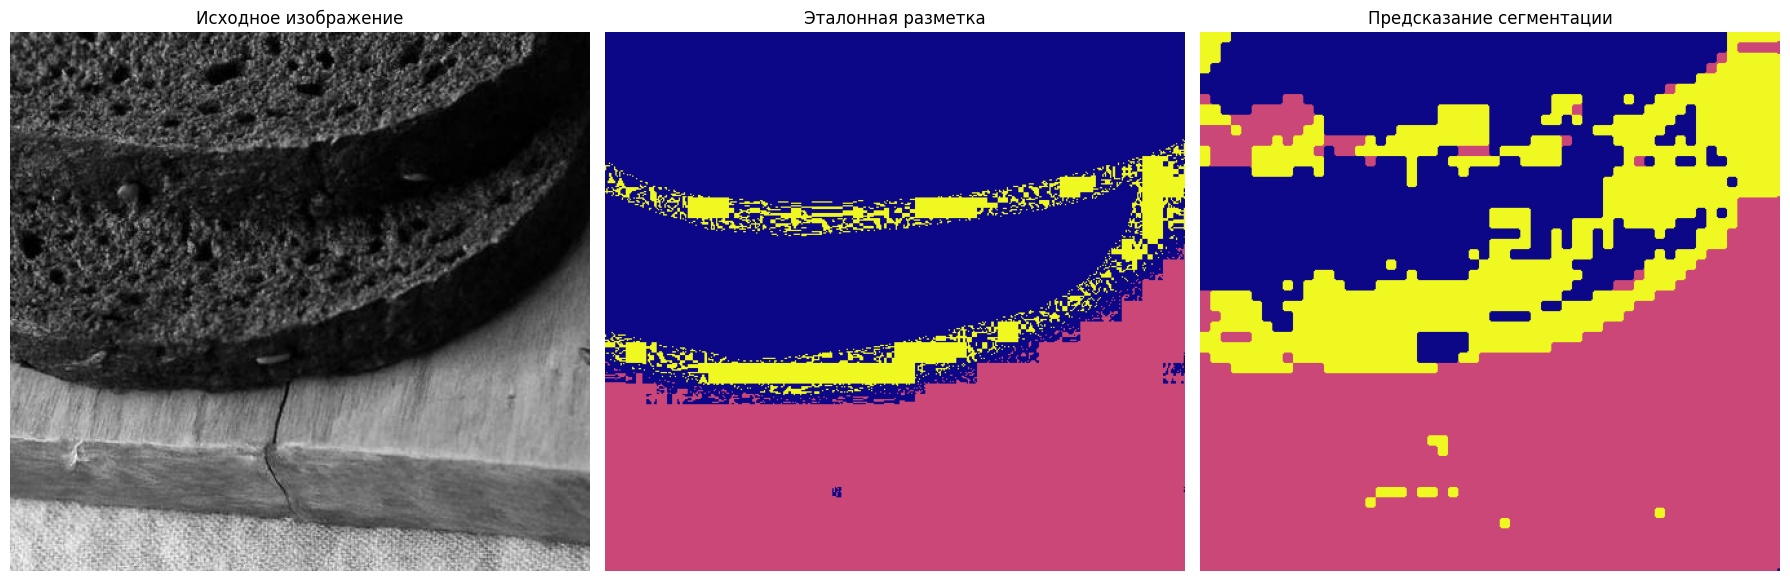

Итоговая точность: 68.3%


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import graycomatrix, graycoprops
import os

def load_dataset(images_dir):
    features_list = []
    categories_list = []
    
    for category_name in os.listdir(images_dir):
        category_path = os.path.join(images_dir, category_name)
        
        if os.path.isdir(category_path) and not category_name.startswith('.'):
            for img_file in os.listdir(category_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(category_path, img_file)
                    
                    img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img_data is not None:
                        feature_vector = compute_texture_descriptors(img_data)
                        features_list.append(feature_vector)
                        categories_list.append(category_name)
    
    return np.array(features_list), np.array(categories_list)

def analyze_image_intensity(gray_img, num_bins=256):
    intensity_dist = cv2.calcHist([gray_img], [0], None, [num_bins], [0, 256])
    intensity_dist = intensity_dist.flatten()
    intensity_dist = intensity_dist / intensity_dist.sum()
    
    intensity_values = np.arange(num_bins)
    stats_results = {}
    
    stats_results['average'] = np.sum(intensity_dist * intensity_values)
    
    variance = np.sum(intensity_dist * (intensity_values - stats_results['average'])**2)
    stats_results['deviation'] = np.sqrt(variance)
    
    if stats_results['deviation'] > 0:
        stats_results['asymmetry'] = np.sum(intensity_dist * ((intensity_values - stats_results['average']) / stats_results['deviation'])**3)
    else:
        stats_results['asymmetry'] = 0
    
    if stats_results['deviation'] > 0:
        stats_results['peakedness'] = np.sum(intensity_dist * ((intensity_values - stats_results['average']) / stats_results['deviation'])**4) - 3
    else:
        stats_results['peakedness'] = -3
    
    non_zero_probs = intensity_dist[intensity_dist > 0]
    stats_results['randomness'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    
    cumulative_dist = np.cumsum(intensity_dist)
    stats_results['percentile_25'] = np.argmax(cumulative_dist >= 0.25) 
    stats_results['percentile_50'] = np.argmax(cumulative_dist >= 0.5)  
    stats_results['percentile_75'] = np.argmax(cumulative_dist >= 0.75) 
    
    occupied_bins = np.where(intensity_dist > 0)[0]
    if len(occupied_bins) > 0:
        stats_results['lowest'] = occupied_bins[0]
        stats_results['highest'] = occupied_bins[-1]
    else:
        stats_results['lowest'] = 0
        stats_results['highest'] = 255
    
    return stats_results, intensity_dist

def compute_texture_descriptors(gray_img, num_bins=256):
    stats, dist = analyze_image_intensity(gray_img, num_bins)
    
    descriptors = [
        stats['average'],
        stats['deviation'],
        stats['asymmetry'],
        stats['peakedness'],
        stats['randomness'],
        stats['percentile_25'],
        stats['percentile_50'], 
        stats['percentile_75'],
        stats['lowest'],
        stats['highest']
    ]
    
    return np.array(descriptors)

def visualize_texture_samples(images_dir, samples_count):
    categories = [f for f in os.listdir(images_dir) 
                 if os.path.isdir(os.path.join(images_dir, f)) and not f.startswith('.')]
    
    fig, axes = plt.subplots(samples_count, 3, figsize=(15, 5*samples_count))
    
    for idx in range(min(samples_count, len(categories))):
        category = categories[idx]
        category_path = os.path.join(images_dir, category)
        
        image_files = [f for f in os.listdir(category_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 0:
            sample_path = os.path.join(category_path, image_files[0])
            sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
            
            if sample_img is not None:
                stats, intensity_plot = analyze_image_intensity(sample_img)
                
                axes[idx, 0].imshow(sample_img, cmap='gray')
                axes[idx, 0].set_title(f'{category}')
                axes[idx, 0].axis('off')
                
                axes[idx, 1].bar(range(256), intensity_plot, alpha=0.7, color='green')
                axes[idx, 1].set_title('Интенсивность пикселей')
                
                stats_text = (
                    f"Среднее: {stats['average']:.2f}\n"
                    f"Отклонение: {stats['deviation']:.2f}\n"
                    f"Асимметрия: {stats['asymmetry']:.2f}\n"
                    f"Эксцесс: {stats['peakedness']:.2f}\n"
                    f"Энтропия: {stats['randomness']:.2f}\n"
                    f"Диапазон: {stats['lowest']}/{stats['highest']}"
                )
                
                axes[idx, 2].text(0.1, 0.9, stats_text, transform=axes[idx, 2].transAxes, 
                                 fontsize=10, verticalalignment='top')
                axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_laws_features(img_data, normalize=True):
    L5 = np.array([1,  4,  6,  4,  1])
    E5 = np.array([-1, -2,  0,  2,  1])
    S5 = np.array([-1,  0,  2,  0, -1])
    W5 = np.array([-1,  2,  0, -2,  1])
    R5 = np.array([1,  -4,  6, -4,  1])
    
    kernels_1d = [L5, E5, S5, W5, R5]
    kernel_labels = ['L5', 'E5', 'S5', 'W5', 'R5']
    
    filters_2d = []
    filter_labels = []
    
    for i, kernel_x in enumerate(kernels_1d):
        for j, kernel_y in enumerate(kernels_1d):
            filter_kernel = np.outer(kernel_x, kernel_y)
            filters_2d.append(filter_kernel)
            filter_labels.append(f"{kernel_labels[i]}{kernel_labels[j]}")
    
    feature_vector = []
    feature_labels = []
    
    for kernel, label in zip(filters_2d, filter_labels):
        filtered_image = cv2.filter2D(img_data.astype(np.float32), -1, kernel)
        texture_energy = np.mean(filtered_image ** 2)
        feature_vector.append(texture_energy)
        feature_labels.append(f"laws_{label}")
    
    feature_vector = np.array(feature_vector)
    
    if normalize and np.sum(feature_vector) > 0:
        feature_vector = feature_vector / np.sum(feature_vector)
    
    return feature_vector, feature_labels

def calculate_glcm_descriptors(img_data, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    img_data = (img_data // 8).astype(np.uint8)
    
    glcm_matrix = graycomatrix(img_data, distances=distances, angles=angles, 
                              levels=32, symmetric=True, normed=True)
    
    descriptors = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for prop in properties:
        descriptor_value = np.mean(graycoprops(glcm_matrix, prop))
        descriptors.append(descriptor_value)
    
    return np.array(descriptors)

images_directory = "./KTH_TIPS"
features_data, target_labels = load_dataset(images_directory)

print(f"Загружено данных: {features_data.shape}")
print(f"Уникальных категорий: {len(np.unique(target_labels))}")

visualize_texture_samples(images_directory, samples_count=2)

image_files_list = []
for category_dir in os.listdir(images_directory):
    full_category_path = os.path.join(images_directory, category_dir)
    if os.path.isdir(full_category_path):
        for filename in os.listdir(full_category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files_list.append(os.path.join(full_category_path, filename))

print(f"Обнаружено изображений: {len(image_files_list)}")

histogram_features = []  
laws_features = []  
glcm_features = []  
image_labels = []      

for idx, file_path in enumerate(image_files_list):
    if idx % 50 == 0:
        print(f"Обработка {idx}/{len(image_files_list)}")
    
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    
    hist_feats = compute_texture_descriptors(img)  
    laws_feats, _ = calculate_laws_features(img)    
    glcm_feats = calculate_glcm_descriptors(img)       
    
    histogram_features.append(hist_feats)
    laws_features.append(laws_feats)
    glcm_features.append(glcm_feats)
    
    category = os.path.basename(os.path.dirname(file_path))
    image_labels.append(category)

histogram_features = np.array(histogram_features)
laws_features = np.array(laws_features) 
glcm_features = np.array(glcm_features)
image_labels = np.array(image_labels)

print(f"Размерность признаков: {histogram_features.shape}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_labels)

feature_sets = {
    'Гистограмма': histogram_features,
    'Laws': laws_features, 
    'GLCM': glcm_features
}

classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),  
    'Дерево': DecisionTreeClassifier(random_state=42, max_depth=10)
}

trained_classifiers = {}

for feature_name, feature_matrix in feature_sets.items():
    print(f"\n{feature_name.upper()}")
    
    X_tr, X_te, y_tr, y_te = train_test_split(
        feature_matrix, encoded_labels, test_size=0.25, random_state=42, stratify=encoded_labels
    )

    normalizer = StandardScaler()
    X_tr_norm = normalizer.fit_transform(X_tr)
    X_te_norm = normalizer.transform(X_te)
    
    current_models = {}
    
    for clf_name, clf_template in classifiers.items():
        if clf_name == 'kNN':
            model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif clf_name == 'SVM':
            model = SVC(kernel='rbf', random_state=42)
        elif clf_name == 'Дерево':
            model = DecisionTreeClassifier(random_state=42, max_depth=10)
        
        if clf_name == 'SVM':
            model.fit(X_tr_norm, y_tr)
            predictions = model.predict(X_te_norm)
            current_models[clf_name] = (model, normalizer)
        else:
            model.fit(X_tr, y_tr)
            predictions = model.predict(X_te)
            current_models[clf_name] = model
        
        print(f"{clf_name}")
        print(classification_report(y_te, predictions, target_names=label_encoder.classes_))
        print()
    
    trained_classifiers[feature_name] = current_models

best_models = {
    'Hist_kNN': trained_classifiers['Гистограмма']['kNN'],  
    'Laws_Tree': trained_classifiers['Laws']['Дерево'],                      
    'Laws_SVM': trained_classifiers['Laws']['SVM']                                     
}

def perform_texture_segmentation(model_data, model_id, input_image_path, window_size=32, stride=16, num_classes=3):
    target_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if target_image is None:
        return None
    
    height, width = target_image.shape
    segmentation_result = np.zeros((height, width), dtype=np.uint8)

    all_predictions = []
    patch_positions = []
    
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            image_patch = target_image[y:y+window_size, x:x+window_size]
            
            if 'Hist' in model_id:
                patch_features = compute_texture_descriptors(image_patch)
            elif 'Laws' in model_id:
                patch_features, _ = calculate_laws_features(image_patch)
            elif 'GLCM' in model_id:
                patch_features = calculate_glcm_descriptors(image_patch)
            
            if isinstance(model_data, tuple):  
                classifier, feature_scaler = model_data
                scaled_features = feature_scaler.transform(patch_features.reshape(1, -1))
                predicted_class = classifier.predict(scaled_features)[0]
            else:  
                classifier = model_data
                predicted_class = classifier.predict(patch_features.reshape(1, -1))[0]
            
            segmentation_result[y:y+window_size, x:x+window_size] = predicted_class
            all_predictions.append(predicted_class)
            patch_positions.append((y, x))

    unique_classes, class_counts = np.unique(all_predictions, return_counts=True)
    
    dominant_classes = unique_classes[np.argsort(class_counts)[-num_classes:]]
    
    filtered_segmentation = np.zeros_like(segmentation_result)
    
    for new_idx, original_class in enumerate(dominant_classes):
        filtered_segmentation[segmentation_result == original_class] = new_idx
    
    remaining_pixels = ~np.isin(segmentation_result, dominant_classes)
    if np.any(remaining_pixels):
        filtered_segmentation[remaining_pixels] = 1 
    
    print(f"Классы после фильтрации: {np.unique(filtered_segmentation)}")
    
    return filtered_segmentation

target_image_path = "./tests/xleb.jpg" 
input_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
reference_mask = cv2.imread("./tests/xleb_mask.jpg", cv2.IMREAD_GRAYSCALE)

print(f"Изображение загружено: {input_image is not None}")
print(f"Маска загружена: {reference_mask is not None}")

if input_image is not None:
    segmentation_results = []
    model_identifiers = []
    
    for model_id, model_data in best_models.items():
        print(f"   Модель: {model_id}")
        
        segmentation_map = perform_texture_segmentation(model_data, model_id, target_image_path,
                                                       window_size=16, stride=8)
        
        if segmentation_map is not None:
            segmentation_results.append(segmentation_map)
            model_identifiers.append(model_id)
            print(f"   Успешно завершено")
        else:
            print(f"   Ошибка обработки")
    
    if segmentation_results:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for idx, (seg_map, model_id) in enumerate(zip(segmentation_results, model_identifiers)):
            if 'Hist' in model_id:
                method_name = 'Гистограмма'
                classifier_type = 'kNN'
            elif 'Laws' in model_id:
                method_name = 'Laws'
                if 'Tree' in model_id:
                    classifier_type = 'Дерево'
                else:
                    classifier_type = 'SVM'
            
            axes[idx].imshow(input_image, cmap='gray', alpha=0.7)
            axes[idx].imshow(seg_map, cmap='viridis', alpha=0.6)
            axes[idx].set_title(f'{method_name} + {classifier_type}', fontsize=12)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Успешно обработано: {len(segmentation_results)}/3")
    else:
        print("Все модели завершились с ошибкой!")
else:
    print(f"Ошибка загрузки: {target_image_path}")

def simplify_color_scheme(mask_array, max_colors=3):
    unique_colors, color_counts = np.unique(mask_array, return_counts=True)
    
    sorted_colors = unique_colors[np.argsort(-color_counts)]
    dominant_colors = sorted_colors[:max_colors]
    
    print(f"Доминирующие цвета: {dominant_colors}")
    print(f"Количество пикселей: {color_counts[np.argsort(-color_counts)[:max_colors]]}")
    
    simplified_mask = np.zeros_like(mask_array)
    
    for new_color, original_color in enumerate(dominant_colors):
        simplified_mask[mask_array == original_color] = new_color
    
    print(f"Сопоставление: {dominant_colors} -> {list(range(len(dominant_colors)))}")
    
    return simplified_mask

reference_mask = cv2.imread("./tests/xleb_mask.jpg", cv2.IMREAD_GRAYSCALE)
if reference_mask is not None:
    processed_reference_mask = simplify_color_scheme(reference_mask, max_colors=3)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(reference_mask, cmap='gray')
    plt.title(f'Исходная маска\n{len(np.unique(reference_mask))} цветов')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(processed_reference_mask, cmap='plasma')
    plt.title('Упрощенная маска\n3 основных цвета')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_segmentation_quality(ground_truth_mask, predicted_mask, model_id, original_image):
    
    if ground_truth_mask.shape != predicted_mask.shape:
        print(f"Размеры масок отличаются: эталон {ground_truth_mask.shape}, результат {predicted_mask.shape}")
        resized_prediction = cv2.resize(predicted_mask, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]), 
                                       interpolation=cv2.INTER_NEAREST)
    else:
        resized_prediction = predicted_mask
    
    gt_classes = np.unique(ground_truth_mask)
    pred_classes = np.unique(resized_prediction)
    
    print(f"Классы в эталоне: {gt_classes}")
    print(f"Классы в предсказании: {pred_classes}")
    
    class_correspondence = {
        0: 2,
        1: 1,  
        2: 0   
    }
    
    aligned_prediction = resized_prediction.copy()
    for pred_class, gt_class in class_correspondence.items():
        aligned_prediction[resized_prediction == pred_class] = gt_class
    
    pixel_accuracy = accuracy_score(ground_truth_mask.flatten(), aligned_prediction.flatten())
    
    print(f"Точность: {pixel_accuracy:.1%}")
    print(f"Метрика IoU по классам:")
    
    for class_id in gt_classes:
        class_iou = jaccard_score(ground_truth_mask.flatten(), aligned_prediction.flatten(), 
                                average=None, labels=[class_id])[0]
        print(f"   Класс {class_id}: {class_iou:.3f}")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    axes[1].imshow(ground_truth_mask, cmap='plasma')
    axes[1].set_title('Эталонная разметка')
    axes[1].axis('off')
    
    axes[2].imshow(aligned_prediction, cmap='plasma')
    axes[2].set_title(f'Предсказание сегментации')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pixel_accuracy

target_image_path = "./tests/xleb.jpg"
input_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

selected_model_id = 'Laws_SVM'
selected_model_data = best_models[selected_model_id]

print("Запуск сегментации...")
result_mask = perform_texture_segmentation(
    selected_model_data, selected_model_id, target_image_path,
    window_size=32, stride=8, num_classes=3
)

print(f"Результат: {result_mask.shape}")
print(f"Классы в результате: {np.unique(result_mask)}")

if processed_reference_mask is not None and result_mask is not None and input_image is not None:
    accuracy_value = evaluate_segmentation_quality(processed_reference_mask, result_mask, selected_model_id, input_image)
    print(f"Итоговая точность: {accuracy_value*100:.1f}%")


    